## II - `merge_LC`

For a given system, this code fetches its different light curves and combines them into one. Before doing so, it clears each dataset from NaNs, infinite values, and bad SAP_QUALITY points, and removes >3sigma outliers. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pylab import rcParams
import time
import astropy
from astropy.io import fits

rcParams['figure.figsize'] = 10, 7

In [2]:
"""
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13up/'
out_path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13up_merged/'
"""

path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
out_path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', 
                                comment='#', na_values = '\\N')

targets = pd.read_csv(path_file+'kepler_id.txt', delimiter=',',
                         dtype=int, header=None, names=['kepid'])

In [3]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("*Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("*Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have short-cadence LC with SN > 7.1 for their first transit'.format(len(sc_data)))
    
sc_data.shape

Check files:
*Lengths don't match: 56 429
	Some systems have both sc and lc data! Remove duplicates.
*Lengths match: 56 56
	Duplicates have been removed.
 A total of 56 systems have short-cadence LC with SN > 7.1 for their first transit


(56, 141)

In [4]:
from collections import OrderedDict

bjd_ref = 2454833

def extract_LC(name):
    id_kep = "%.0f" % name
    files = glob(path_file+'kplr*'+id_kep+'*.fits')
     
    clean_time_bkjd = np.array([])
    clean_time_bjd = np.array([])
    clean_flux = np.array([])
    clean_flux_err = np.array([])
    detrended_flux = np.array([])
    
    for lc in files:
        #print(lc)
        hdulist = fits.open(lc)
        header_fits = hdulist[0]
        lc_info = hdulist[1]

        science_data = lc_info.data
        
        x = science_data['TIME'] # Barycenter Kepler Julian Day, BKJD
        y = science_data['PDCSAP_FLUX'] #flujo corregido
        yerr = science_data['PDCSAP_FLUX_ERR'] #error flujo corregido
        q = science_data['SAP_QUALITY']
        
        hdulist.close()
        
        #Clean data from bad quality points
        y[q != 0] = np.nan
        mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(yerr)
        x, y, yerr = x[mask], y[mask], yerr[mask]
       
        #Remove 3sigma points
        errorLC = np.std(y)
        goodP = y <= np.mean(y)+3*errorLC
 
        #Clean data of >3 sigma outliers and normalize
        clean_time_bkjd = np.append(clean_time_bkjd, x[goodP])
        clean_flux = np.append(clean_flux, (y[goodP]/np.nanmedian(y[goodP])))
        clean_flux_err = np.append(clean_flux_err, yerr[goodP]/np.nanmedian(yerr[goodP])) 
    
    targetLC = pd.DataFrame(OrderedDict({'Time BKJD': clean_time_bkjd, 
                                         'Flux': clean_flux, 
                                         'Flux_Err': clean_flux_err}))
    
    cols = list(targetLC.columns.values)
    targetLC = targetLC[['Time BKJD', 'Flux', 'Flux_Err']]
    plt.figure()
    plt.plot(clean_time_bkjd,clean_flux,'.')
    plt.show(block=False)
    time.sleep(2)
    plt.close()
    
    np.savetxt(out_path_file+'KID'+id_kep+'.txt', targetLC.values, fmt='%f', delimiter="\t", 
               header = 'Time BKJD\tFlux\tFlux Err')

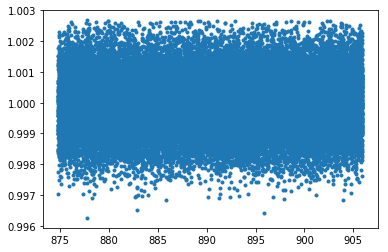

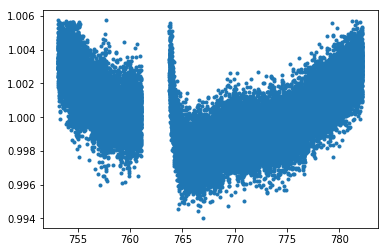

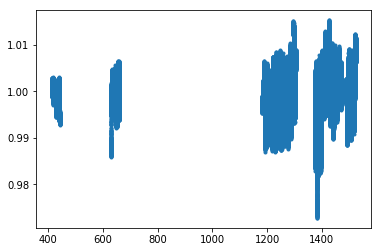

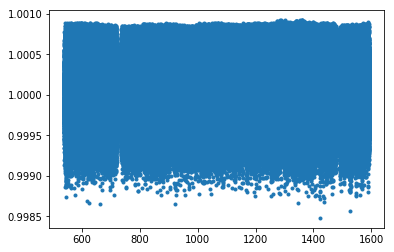

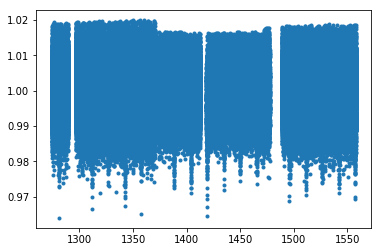

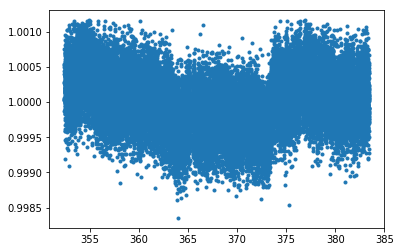

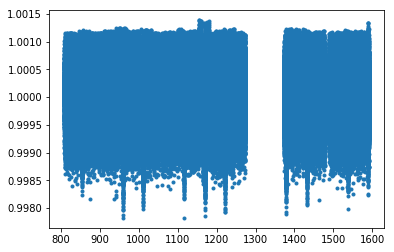

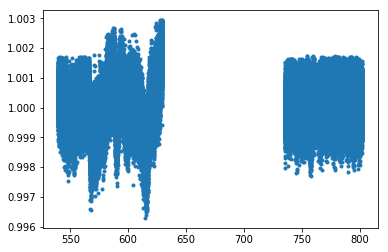

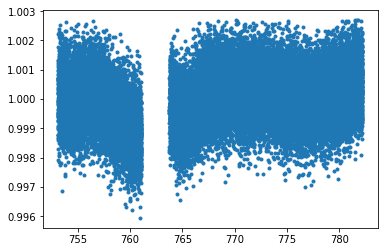

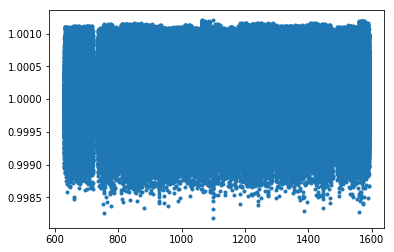

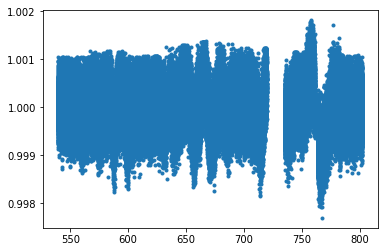

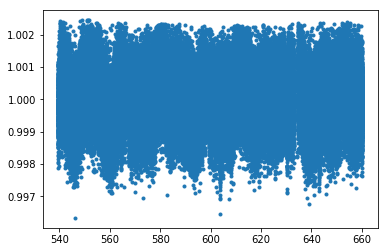

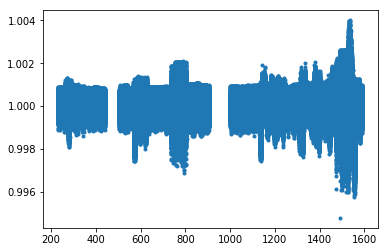

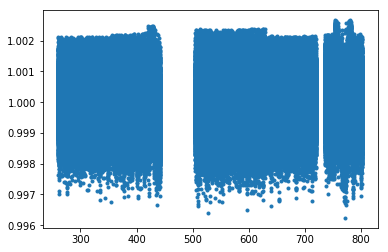

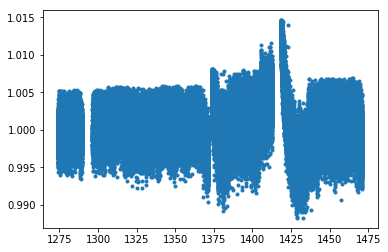

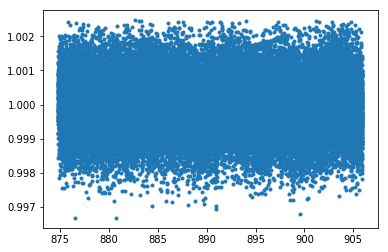

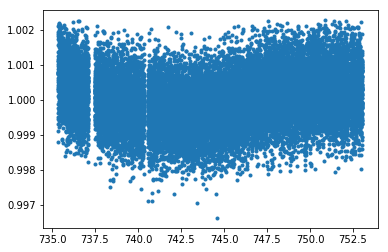

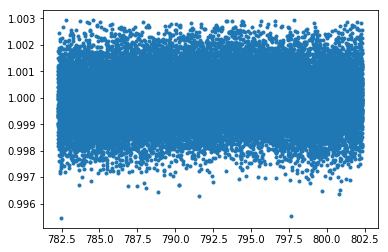

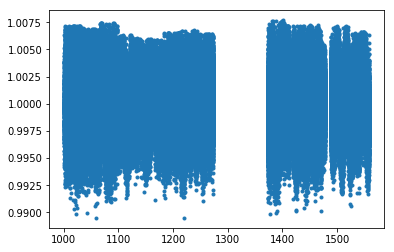

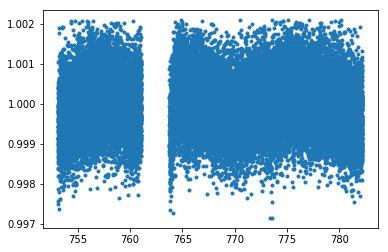

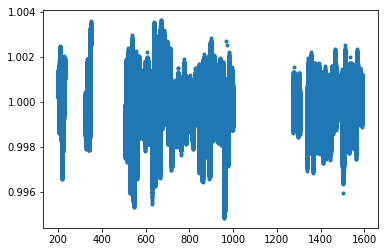

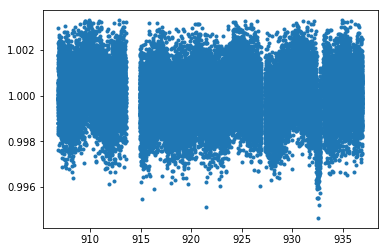

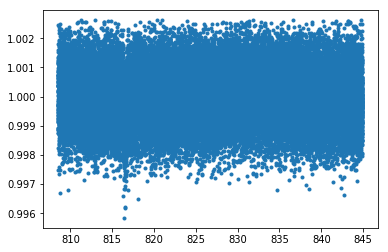

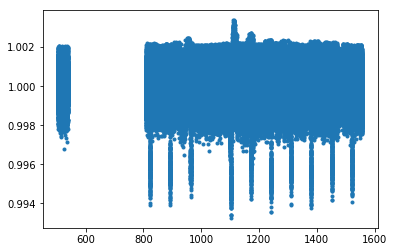

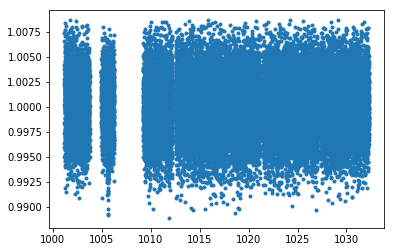

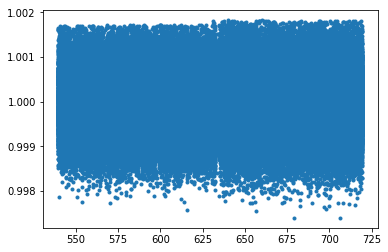

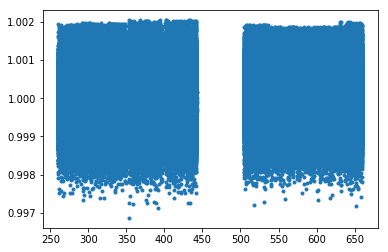

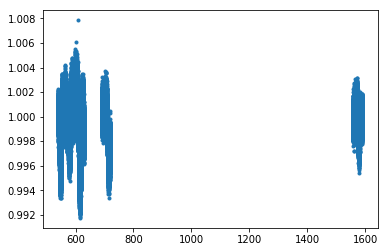

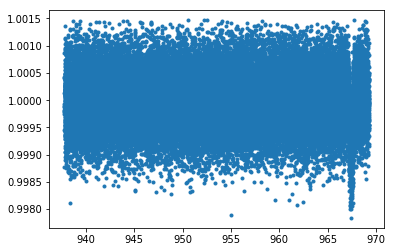

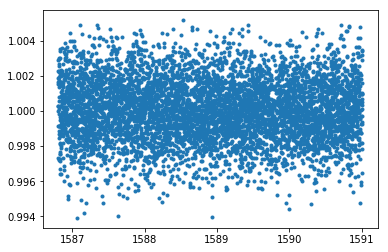

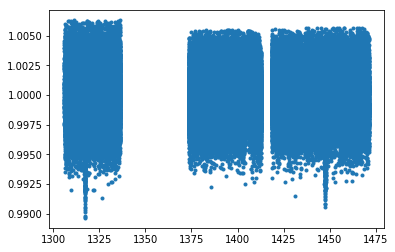

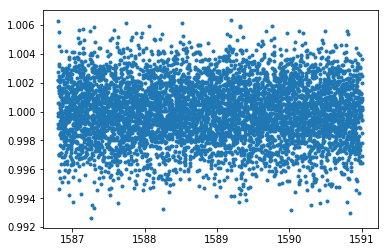

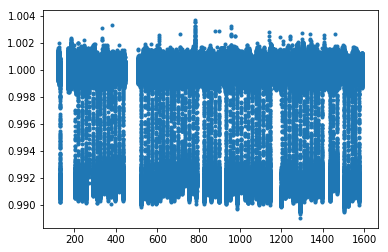

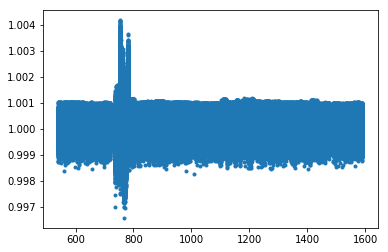

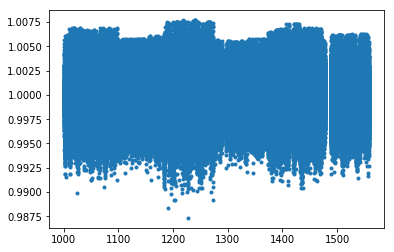

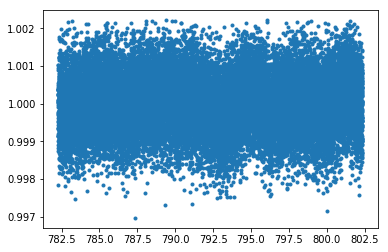

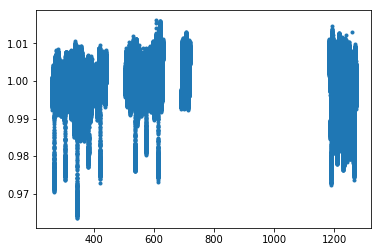

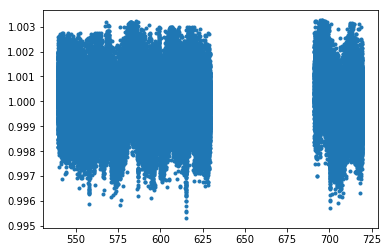

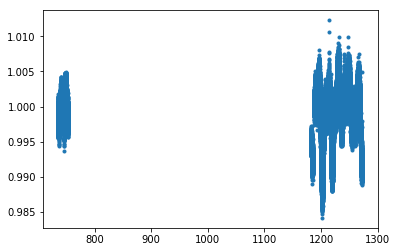

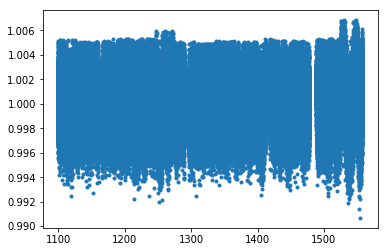

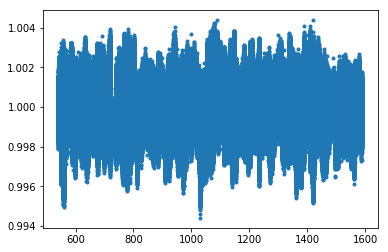

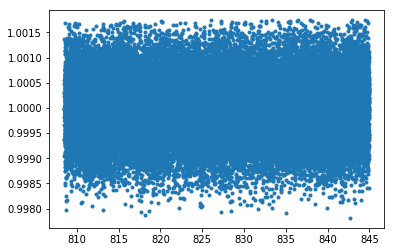

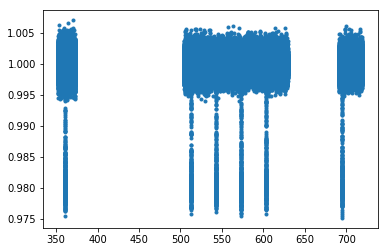

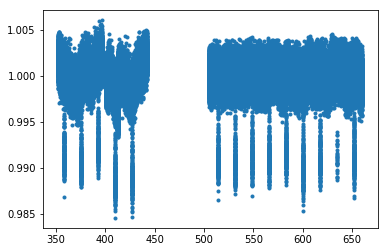

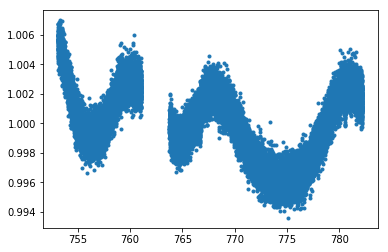

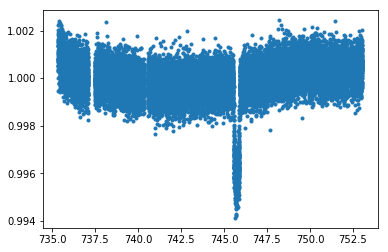

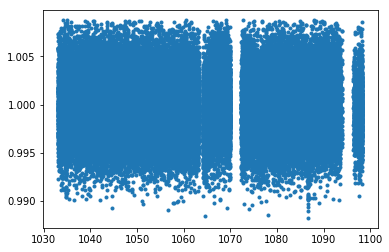

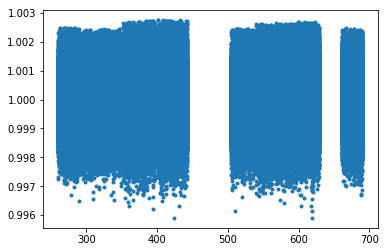

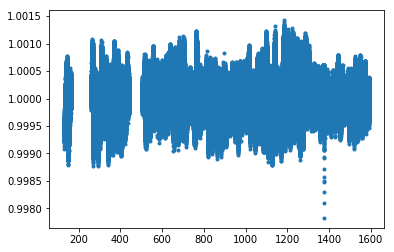

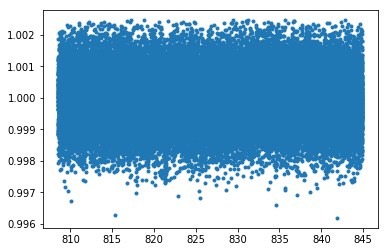

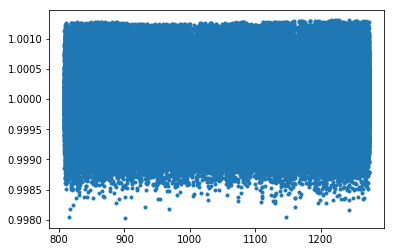

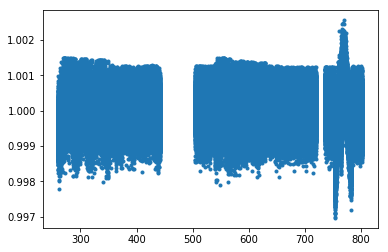

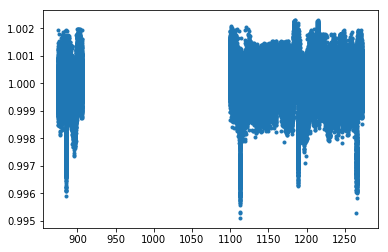

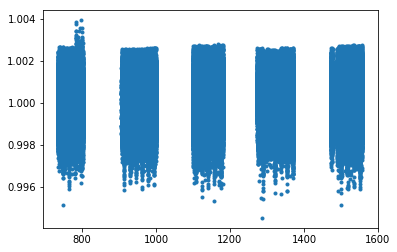

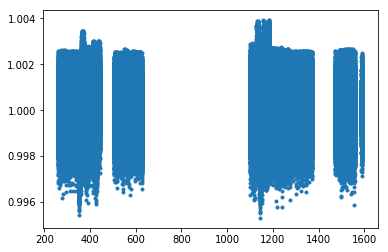

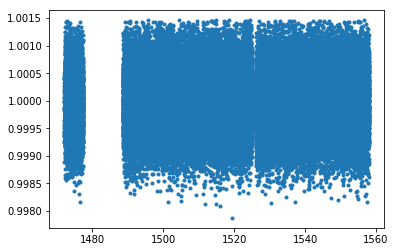

In [5]:
for row in sc_data.itertuples(index=True, name='Pandas'):
    kepid = getattr(row, "kepid")
    extract_LC(kepid)